In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import tensorflow as t
from tensorflow.data import experimental
from matplotlib import gridspec
%matplotlib inline

In [ ]:
#run every session
#takes about 3 mins to run
drive.mount('/content/drive')
shared_folder_path = '/content/drive/MyDrive/DATASCI 207 Project/data'
file_path = os.path.join(shared_folder_path, 'LSWMD.pkl')
print(file_path)
df = pd.read_pickle(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DATASCI 207 Project/data/LSWMD.pkl


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


811,457 total records.

Column 4 is misspelled. Fixing that.

In [ ]:
df.rename(columns = {'trianTestLabel':'trainTestLabel'}, inplace = True)

In [ ]:
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType
473276,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29153,9.0,[],[]
241233,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1282.0,lot15022,11.0,[],[]
664744,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",712.0,lot41401,5.0,[],[]
479376,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29678,11.0,[],[]
232012,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2085.0,lot14529,2.0,[[Training]],[[Edge-Ring]]


waferMap is an array, dieSize and waferIndex are floats.

We will probably only be interested in the waferMap (image) and the failureType(label). But will explore more before dropping anything.

trainTestLabel and failureType are inside brackets, which will throw errors because Python will interpret it as a list. No reason for it to be inside brackets, so we'll exract those values as strings.

In [ ]:
def extract_string(x):
    if isinstance(x, list) and len(x) > 0:
        return x[0]
    elif isinstance(x, np.ndarray) and x.size > 0:
        return x.item(0)
    return x

df['failureType'] = df['failureType'].apply(extract_string)
df['trainTestLabel'] = df['trainTestLabel'].apply(extract_string)

df['failureType'] = df['failureType'].astype(str)
df['trainTestLabel'] = df['trainTestLabel'].astype(str)

trainTestLabel
[]          638507
Test        118595
Training     54355
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Train, Test, and []'}, xlabel='trainTestLabel', ylabel='Frequency'>

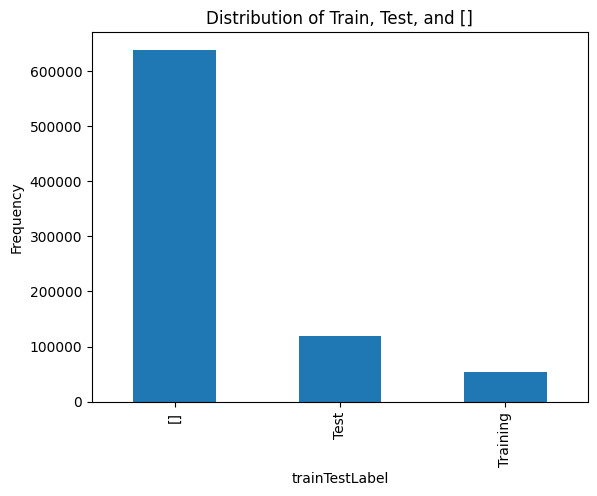

In [ ]:
print(df['trainTestLabel'].value_counts().sort_values(ascending = False))
df['trainTestLabel'].value_counts().sort_values(ascending = False).plot(kind='bar', title='Distribution of Train, Test, and []', ylabel='Frequency')

The highest count for trainTestLabel is '[]' and the train/test split appears to be 30/70. Is that a split we want to stick with?

Same for failureType (see below) with the brackets. 'None' is its own label, so what do the brackets mean? Maybe we just remove those rows.

failureType
[]           638507
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Failure Types'}, xlabel='failureType', ylabel='Frequency'>

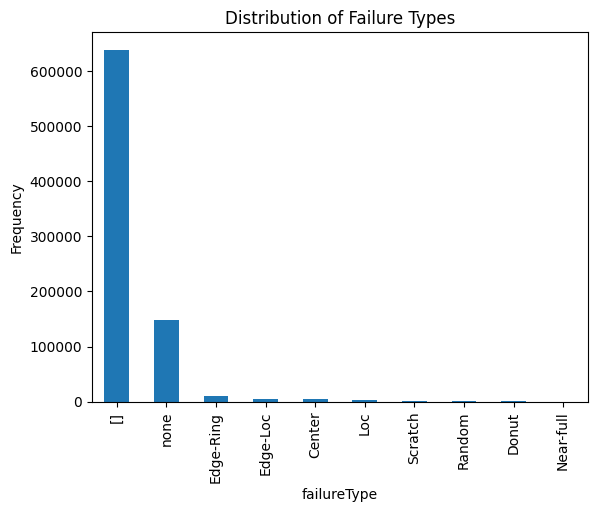

In [ ]:
print(df['failureType'].value_counts().sort_values(ascending = False))
df['failureType'].value_counts().sort_values(ascending = False).plot(kind='bar', title='Distribution of Failure Types', ylabel='Frequency')
# plt.hist(df['failureType'], bins=np.arange(11)-0.5, edgecolor='black', linewidth=1.2)
# plt.title('Distribution of Failure Types')
# plt.xlabel('Failure Types')
# plt.xticks(rotation=305)
# plt.ylabel('Frequency')

WAAAAAYYYY unbalanced. The brackets are dwarfing the wafers with failures, strengthening the argument for dropping rows with that value. None is also high, but we may be able to sample/batch None.

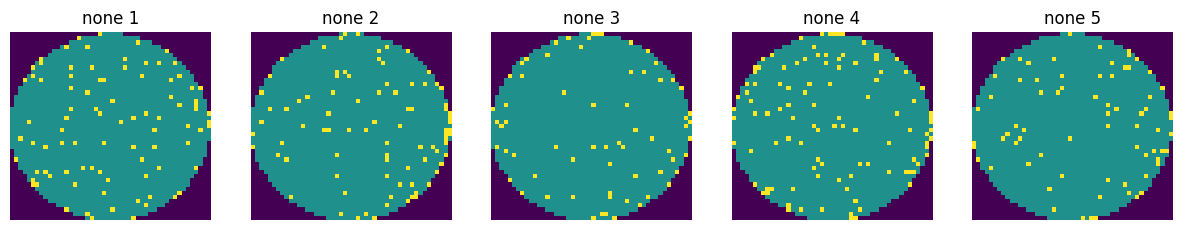

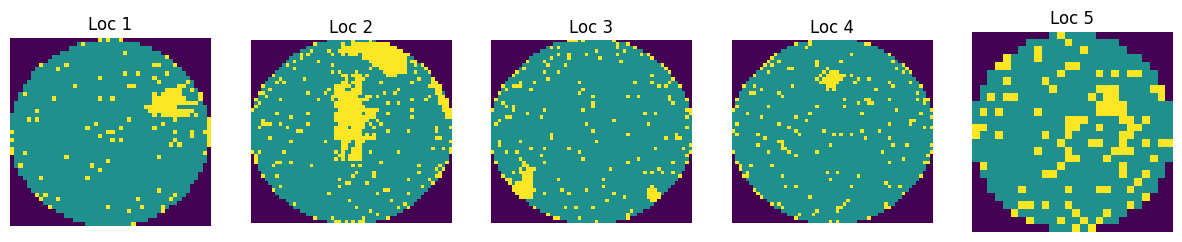

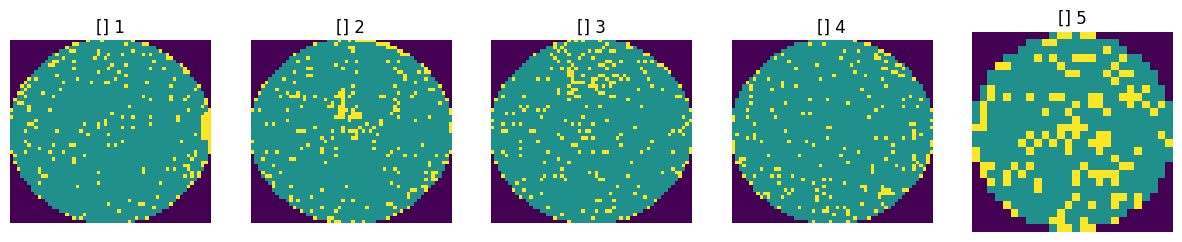

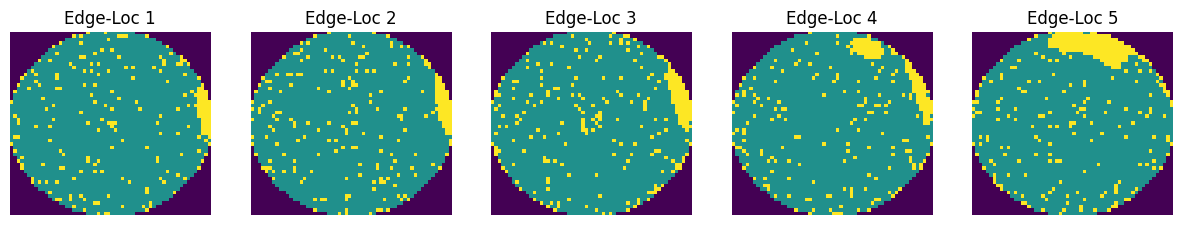

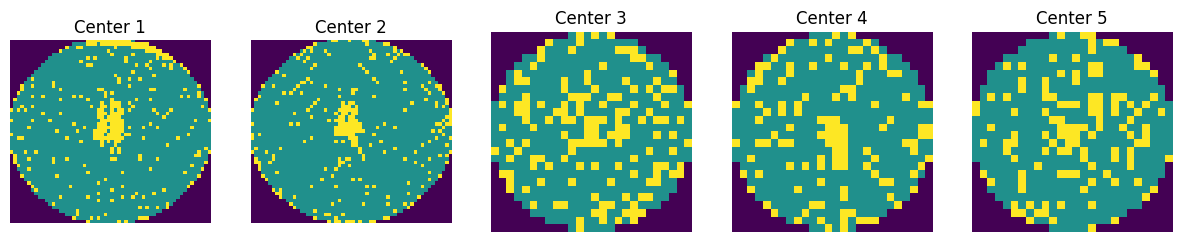

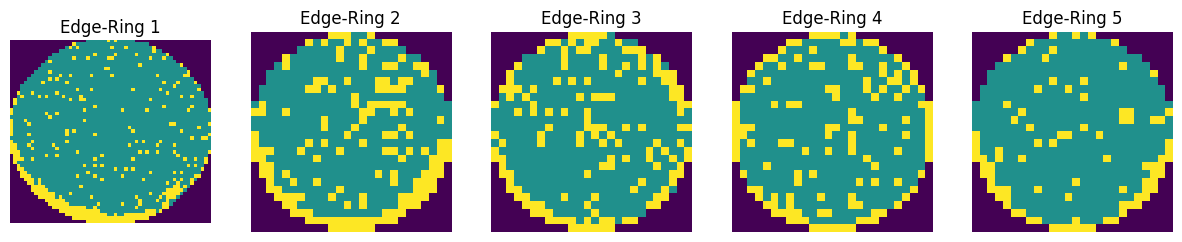

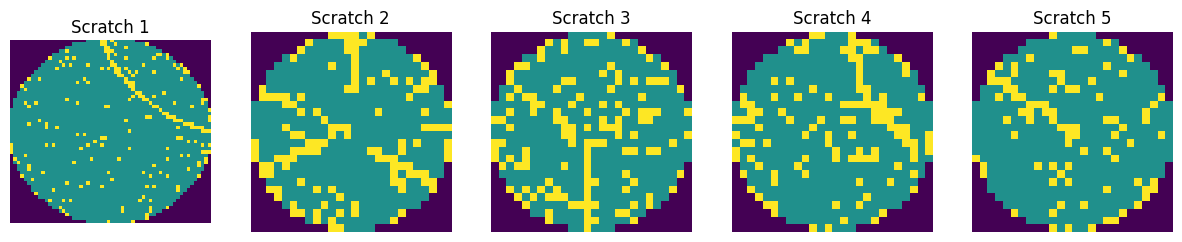

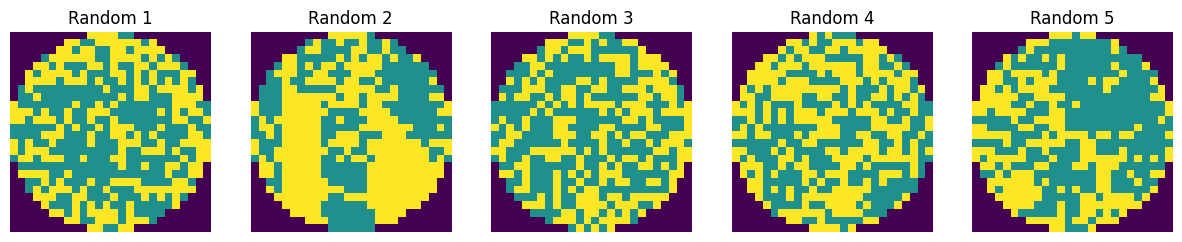

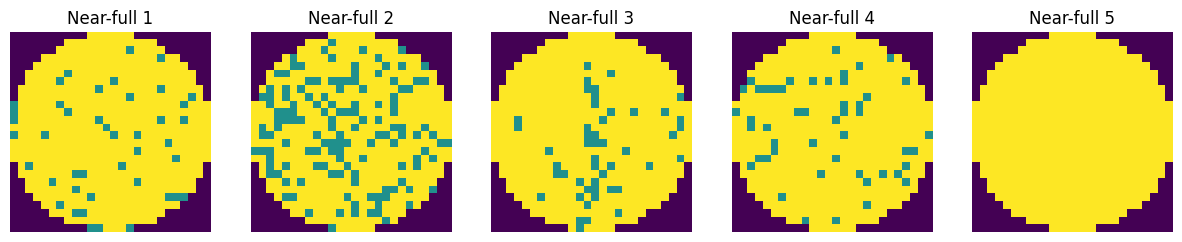

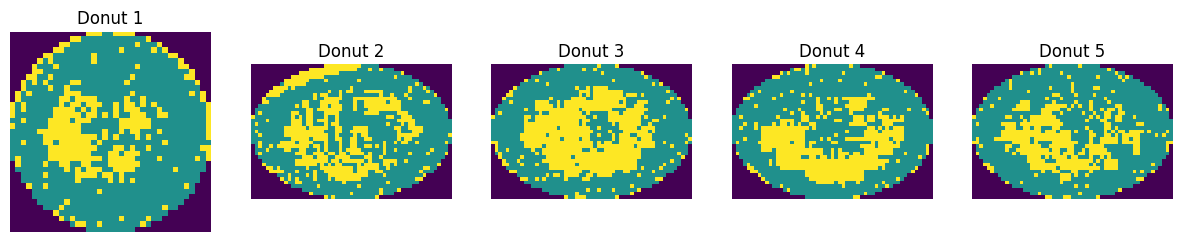

In [ ]:
for failure_type in df['failureType'].unique():
    filtered_df = df[df['failureType'] == failure_type]
    num_maps = min(5, len(filtered_df))

    plt.figure(figsize=(15, 3 * num_maps))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        wafer_map = filtered_df.iloc[i]['waferMap']
        plt.imshow(wafer_map, interpolation='none')
        plt.title(f'{failure_type} {i + 1}')
        plt.axis('off')
    plt.show()

The Donut images are strangely shaped. We will need to resize/reshape the images so they match.

In [ ]:
def get_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']= df['waferMap'].apply(lambda x: get_dim(x))
df.head(5)

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


waferMapDim
(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(6, 21)          1
(15, 3)          1
(21, 17)         1
(27, 15)         1
(27, 71)         1
Name: count, Length: 632, dtype: int64


<Axes: title={'center': 'Distribution of Top 20 Wafer Map Dimensions'}, xlabel='waferMapDim', ylabel='Frequency'>

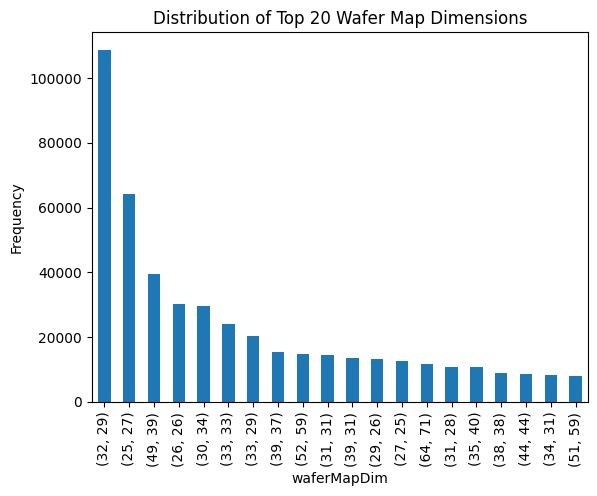

In [ ]:
print(df["waferMapDim"].value_counts().sort_values(ascending = False)) #which ones to pick? (Is this something we need to do now? Might be better to address after splits) Divide pixels by 255.0?
df["waferMapDim"].value_counts().sort_values(ascending = False).head(20).plot(kind='bar', title='Distribution of Top 20 Wafer Map Dimensions', ylabel='Frequency')

failureType
[]           15712
none         13489
Loc            297
Edge-Loc       296
Center          90
Random          74
Scratch         72
Edge-Ring       31
Near-full       16
Donut            1
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Wafer Map Errors'}, xlabel='failureType', ylabel='Frequency'>

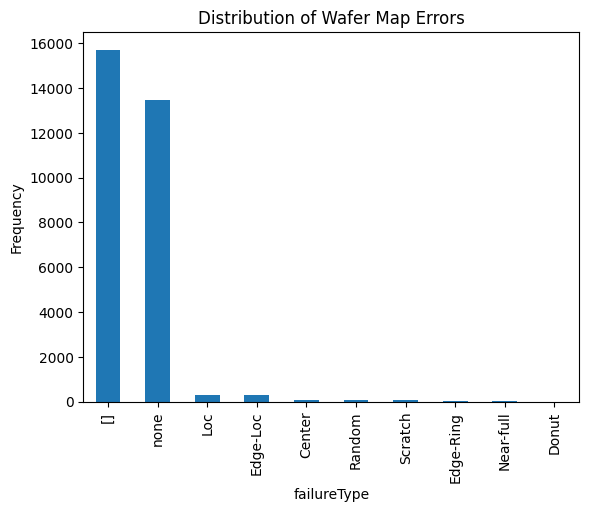

In [ ]:
print(df[df["waferMapDim"]==(26,26)]["failureType"].value_counts())
df[df["waferMapDim"]==(26,26)]["failureType"].value_counts().plot(kind='bar', title='Distribution of Wafer Map Errors', ylabel='Frequency')

In [ ]:
df_26_26 = df[(df["waferMapDim"] == (26, 26)) & (df["failureType"] != "[]")]
df_25_27 = df[(df["waferMapDim"] == (25, 27)) & (df["failureType"] != "[]")]
df_27_25 = df[(df["waferMapDim"] == (27, 25)) & (df["failureType"] != "[]")]

<ipython-input-39-7a1344941aa9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25_27['waferMap_resized'] = df_25_27['waferMap'].apply(lambda x: resize_to_target(x, target_size=(26, 26)))
<ipython-input-39-7a1344941aa9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_27_25['waferMap_resized'] = df_27_25['waferMap'].apply(lambda x: resize_to_target(x, target_size=(26, 26)))


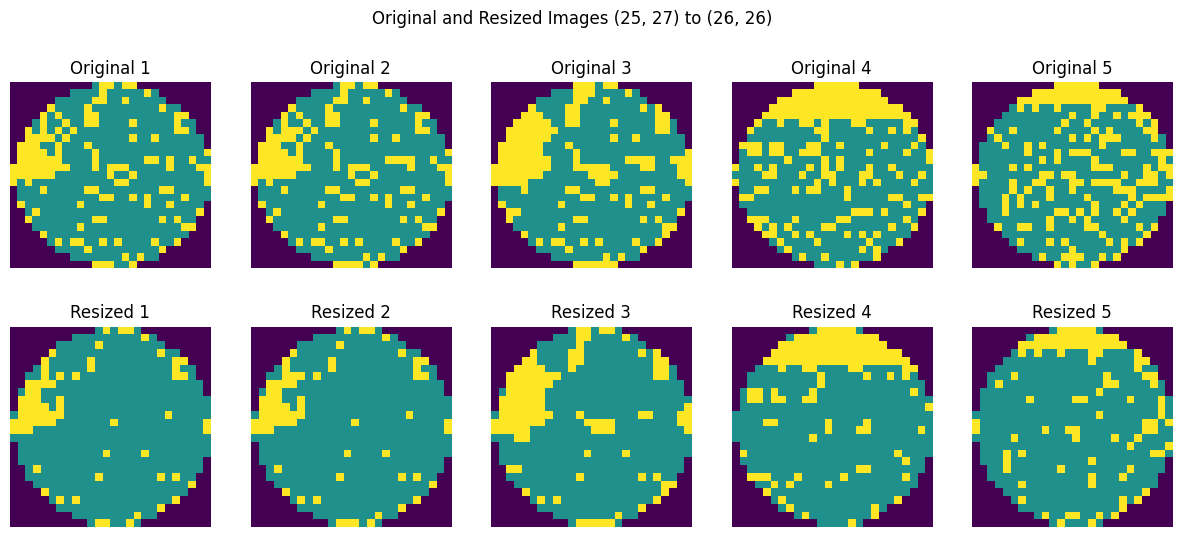

In [ ]:
def resize_to_target(wafer_map, target_size=(26, 26)):
    return cv2.resize(wafer_map, dsize=target_size, interpolation=cv2.INTER_LINEAR)

df_25_27['waferMap_resized'] = df_25_27['waferMap'].apply(lambda x: resize_to_target(x, target_size=(26, 26)))
df_27_25['waferMap_resized'] = df_27_25['waferMap'].apply(lambda x: resize_to_target(x, target_size=(26, 26)))


num_images = 5
plt.figure(figsize=(15, 6))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(df_25_27['waferMap'].iloc[i], interpolation='none')
    plt.title(f'Original {i + 1}')
    plt.axis('off')

    # Resized image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(df_25_27['waferMap_resized'].iloc[i], interpolation='none')
    plt.title(f'Resized {i + 1}')
    plt.axis('off')

plt.suptitle('Original and Resized Images (25, 27) to (26, 26)')
plt.show()

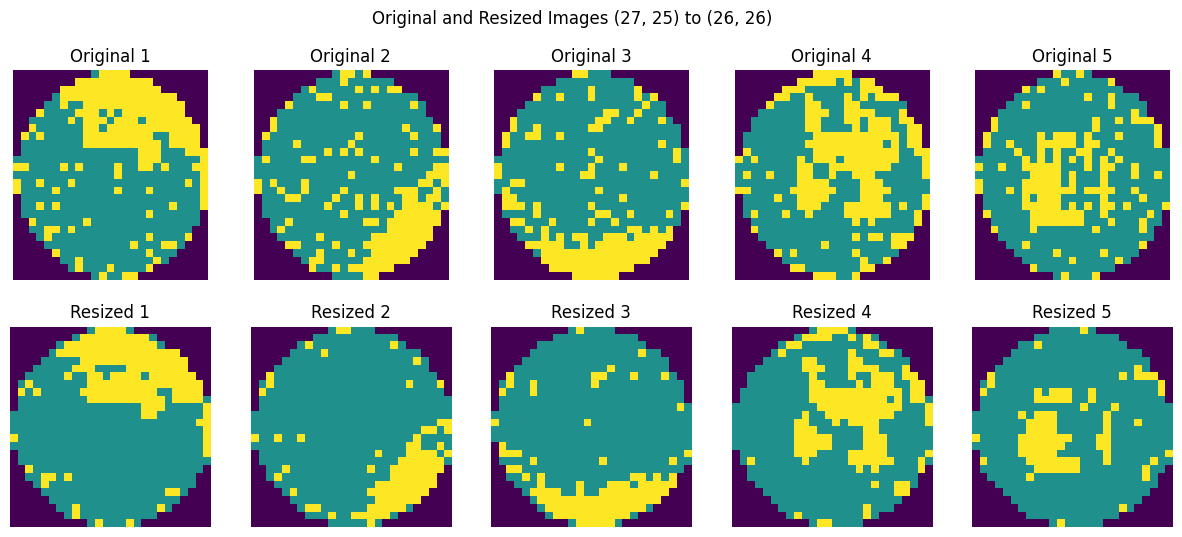

In [ ]:
num_images = 5
plt.figure(figsize=(15, 6))
for i in range(num_images):
    # Original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(df_27_25['waferMap'].iloc[i], interpolation='none')
    plt.title(f'Original {i + 1}')
    plt.axis('off')

    # Resized image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(df_27_25['waferMap_resized'].iloc[i], interpolation='none')
    plt.title(f'Resized {i + 1}')
    plt.axis('off')

plt.suptitle('Original and Resized Images (27, 25) to (26, 26)')
plt.show()

In [ ]:
df_combined = pd.concat([df_26_26, df_25_27, df_27_25])

In [ ]:
df_combined["failureType"].value_counts()

,count
failureType,
none,39795
Center,2364
Edge-Loc,747
Loc,573
Random,137
Scratch,102
Edge-Ring,56
Near-full,48
Donut,7


----------------------------------------------

I just want to try this image processing to see if it solves our size issue. -Alex

In [ ]:
def scale_resize_image(image, label, size):
  image = tf.image.convert_image_dtype(image, tf.float32) # eq to dividing pixels by 255
  image = tf.image.resize(image, size)
  return(image, label)

In [ ]:
df2 = df.copy()
df2.drop(labels = ['dieSize', 'lotName', 'waferIndex'], axis = 1, inplace = True)
df2.head()

,waferMap,trainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"


In [ ]:
# df2.drop(df2.loc[df2['failureType'] == '[]'].index, inplace = True)
# df2.reset_index(drop = True, inplace = True)
# df2['failureType'].value_counts()

In [ ]:
df2['failureClass'] = df2.failureType
df2['trainTestClass'] = df2.trainTestLabel
map_type = {'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7, 'none':8}
map_label = {'Training':0, 'Test':1}
df2 = df2.replace({'failureClass':map_type, 'trainTestClass':map_label})
df2.head()


,waferMap,trainTestLabel,failureType,waferMapDim,failureClass,trainTestClass
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)",8,0


In [ ]:
df2['waferMap'].shape

(811457,)

Not sure this is right, the images should have more dimensions than this. We'll have to reshape.

In [ ]:
# The '[]' brackets are messing this up. Do I drop?

num_wafers = df2.shape[0]
df2_withlabel = df2[(df2['failureClass'] >= 0) & (df2['failureClass'] <= 8)]
df2_withlabel = df2_withlabel.reset_index()
df2_withpattern = df2[(df2['failureClass'] >= 0) & (df2['failureClass'] <= 8)]
df2_withpattern = df2_withpattern.reset_index()
df2_nopattern = df2[(df2['failureClass'] == 8)]
df2_withlabel.shape, df2_withpattern.shape, df2_nopattern.shape

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
# fig = plt.figure(figsize=(20, 4.5))
# gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
# ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])

# no_wafers=[num_wafers-df2_withlabel.shape[0], df2_withpattern.shape[0], df2_nonpattern.shape[0]]

# colors = ['blue', 'green', 'red']
# explode = (0.1, 0, 0)  # explode 1st slice
# labels = ['no-label','label and pattern','label and non-pattern']
# ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

# uni_pattern=np.unique(df2_withpattern.failureNum, return_counts=True)
# labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
# ax2.bar(uni_pattern[0],uni_pattern[1]/df2_withpattern.shape[0], color='green', align='center', alpha=0.9)
# ax2.set_title("failure type frequency")
# ax2.set_ylabel("% of pattern wafers")
# ax2.set_xticklabels(labels2)

# plt.show()